# Inflation, Unemploymet and Real GDP

In this project we aim to examine the historical trends in inflation rates, unemployment and real GDP in Denmark. 

Inflation is the rate at which the general prices for goods and services change increase, corresponding to a decrease in purchasing power of money. Gross Domestic Product (GDP) is a measure of a country's yearly production. We use this to assess the econimic well-being in Denmark in a given time-period.
Data is retrieved from Statitics Denmark. We utilize API's to import data on inflation rates (PRIS111) and unemployment (AULP01). Data on GDP (NAN1) is retrieved from a CSV file. Yearly inflation rates are set as end-of-year rates (M12). Furthermore, we will examine the relationship between inflation, unemployment, and GDP. We investigate the correlation between these variables and link it to the Phillips curve.

**Table of contents**<a id='toc0_'></a>    
- 1. [Inflation](#toc1_)
- 2. [Unemployment and merged data](#toc2_)    
- 3. [Real GDP Denmark](#toc3_)
- 4. [Analyzing GDP Denmark](#toc4_)       
- 5. [Conclusion](#toc5_)  

Imports and load of relevant libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px 
import plotly.graph_objects as go
from dstapi import DstApi


#import pandas_datareader # install with `pip install pandas-datareader`
#from dstapi import DstApi # install with `pip install git+https://github.com/alemartinello/dstapi`
#pip install plotly

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# User written modules
import dataproject as dp

plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})

## 1. <a id='toc1_'></a>[Inflation](#toc0_)

## Reading and cleaning data (inflation)


In [2]:
def fetch_and_prepare_data():
    # Dictionary mappings for renaming and processing
    columns_dict = {'VAREGR': 'variable', 'ENHED': 'unit', 'TID': 'Year', 'INDHOLD': 'Inflation rate'}
    var_dict = {'00 Consumer price index, total': 'Y'}
    unit_dict = {'Index': 'Indexnumber', 'Percentage change compared to previous month (per cent)': 'pct month', 
                 'Percentage change compared to same month the year before (per cent)': 'pct Year'}

    # Retrieving and processing inflation data from Statistics Denmark API
    PRIS111_api = DstApi('PRIS111')
    params = PRIS111_api._define_base_params(language='en')
    PRIS111 = PRIS111_api.get_data(params)

    # Renaming and replacing values
    PRIS111.rename(columns=columns_dict, inplace=True)
    PRIS111['variable'].replace(var_dict, inplace=True)
    PRIS111['unit'].replace(unit_dict, inplace=True)

    # Convert string values to numeric and sort DataFrame by year
    PRIS111['Year'] = pd.to_numeric(PRIS111['Year'].str.replace('M12', ''), errors='coerce')
    PRIS111['Inflation rate'] = pd.to_numeric(PRIS111['Inflation rate'], errors='coerce')
    PRIS111 = PRIS111[(PRIS111['variable'] == 'Y') & (~PRIS111['unit'].isin(['Indexnumber', 'pct month'])) & 
                      (PRIS111['Year'].notna()) & (PRIS111['Year'] >= 2007) & (PRIS111['Year'] != 2023)]
    PRIS111.sort_values(by='Year', inplace=True)
    PRIS111['Year'] = PRIS111['Year'].astype(int)
    return PRIS111


In [3]:
# Fetching and preparing data
inflation_data = fetch_and_prepare_data()

In [4]:
inflation_data.head(5)

,variable,unit,Year,Inflation rate
292217,Y,pct Year,2007,2.3
6548,Y,pct Year,2008,2.4
14901,Y,pct Year,2009,1.4
132900,Y,pct Year,2010,2.8
99939,Y,pct Year,2011,2.4


# Plotting data

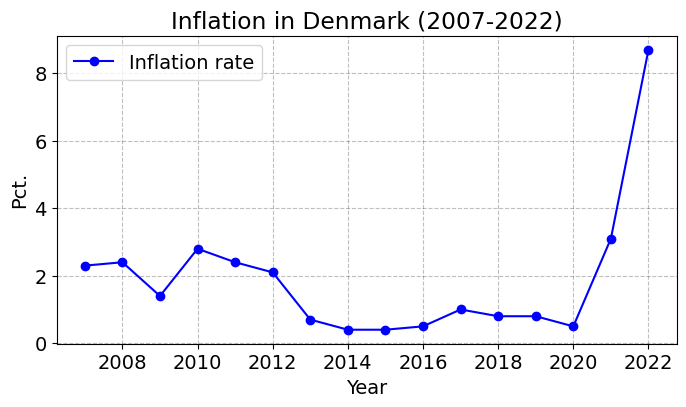

In [27]:
dp.plot_graph_j(x1 = inflation_data['Year'], y1 = inflation_data['Inflation rate'], title='Inflation in Denmark (2007-2022)', xlabel='Year', ylabel='Pct.', label_a='Inflation rate')

We observe inflation in Denmark in the period 2007-22. Initially, it remained moderate, hovering between 2.3 pct. and 2.8 pct. from 2007 to 2011. This period saw generally stable economic conditions. A significant drop occurred between 2012 and 2015, with inflation rates falling to lows of 0.4% and 0.7%. This could indicate that the economy possibly was influenced by global financial challenges. From 2016 to 2019, inflation was consistent between 0.5 pct. and 1.0 pct, suggesting stable but slow economic growth. However, a sharp increase is observed in 2021 and 2022, with rates increasing to 3.1 pct. and 8.7 pct. The relatively large increase in inflation to 8.7 pct. was mostly due to changes in prices in residential use, electricity, and heating. 

NB: we restrict ourselves to 2022, since there's not yet data for unemployment in 2023. In December 2023, inflation drops to 0.7 pct., which was largely due to decreasing energy prices. 

## 2. <a id='toc2_'></a>[Unemployment and merged data](#toc0_)

# Reading and cleaning data (unemployment)

In [6]:
# Retrieving and processing data for unemployment
FT_api = DstApi('AULP01')
params = FT_api._define_base_params(language='en')
params['variables'][0]['values'] = ['000']
params['variables'][1]['values'] = ['TOT']
params['variables'][2]['values'] = ['TOT']
params['variables'][3]['values'] = ['2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022']
unemp = FT_api.get_data(params=params)
unemp.rename(columns={'TID':'Year','INDHOLD':'Unemployment'}, inplace=True)
unemp['Year'] = pd.to_numeric(unemp['Year'], errors='coerce')
unemp['Unemployment'] = pd.to_numeric(unemp['Unemployment'], errors='coerce')
unemp.sort_values(by='Year', inplace=True)

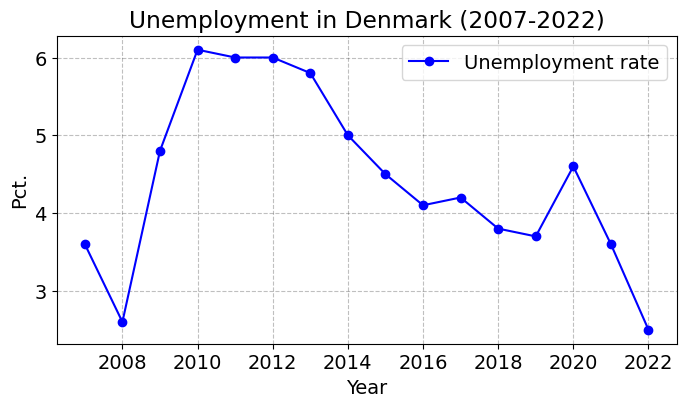

In [29]:
dp.plot_graph_j(x1 = unemp['Year'], y1 = unemp['Unemployment'], title='Unemployment in Denmark (2007-2022)', xlabel='Year', ylabel='Pct.', label_a='Unemployment rate',)

## Merging inflation- and unemployment data from Statistics Denmark

In [8]:
# Merging and sorting data
merged = pd.merge(inflation_data, unemp, how='left', on='Year')
merged.sort_values(by='Year', inplace=True)
Combined_data = merged[['Year', 'Inflation rate', 'Unemployment']]

# Displaying merged data

In [9]:
# Displaying the first few rows of the DataFrame
display(Combined_data.head(5))

,Year,Inflation rate,Unemployment
0,2007,2.3,3.6
1,2008,2.4,2.6
2,2009,1.4,4.8
3,2010,2.8,6.1
4,2011,2.4,6.0


# Plotting the combined data

In [33]:
# Creating the interactive plot
fig = go.Figure()

# Adding traces for both Inflation Rate and Unemployment Rate
fig.add_trace(go.Scatter(x=Combined_data['Year'], y=Combined_data['Inflation rate'],
                         mode='lines+markers', name='Inflation Rate'))
fig.add_trace(go.Scatter(x=Combined_data['Year'], y=Combined_data['Unemployment'],
                         mode='lines+markers', name='Unemployment Rate'))

# Layout
fig.update_layout(
    title='Inflation and Unemployment Over Time',
    xaxis_title='Year',
    yaxis_title='Rate',
    updatemenus=[
        dict(
            type="buttons",
            direction="left",
            buttons=list([
                dict(label="Show Merged Plot",
                     method="update",
                     args=[{"visible": [True, True]},
                           {"title": "Inflation and Unemployment Over Time (2007-2022)"}]),
            ]),
        )
    ]
)

# Showing plot
fig.show()

Inflation and unemployment in Denmark from 2007 to 2022 is observed. Initially, inflation rates levels were moderate between 2.3 pct. and 2.8 pct. This coincided with stable unemployment rates from 2007 to 2011, peaking slightly in 2010 at 6.1 pct., reflecting the global economic downturn. Between 2012 and 2015 inflation rates fell to 0.4 and 0.7 pct. respectively. Unemployment rates stabilizing around 6 pct. 
From 2016 to 2019, both inflation and unemployment displayed steady trends in form of mild inflation between 0.5 pct. and 1.0 pct. paired with a declining unemployment rate, stabilizing around 4 pct., suggested a period of economic recovery. The sharp inflation increase in 2021 and 2022 to 3.1 pct. and 8.7 pct., primarily driven by spikes in residential use costs, electricity, and heating, occurred alongside a substantial drop in unemployment to a record low of 2.6 pct., indicating a complex interplay of rapid price increases and tightening labor markets. Thus it may seem, that inflation and unemployment has an inverse relationship.

## 3. <a id='toc3_'></a>[Real GDP Denmark](#toc0_)

In [11]:
# Importing data from CSV file 'Real GDP'
GDP = pd.read_csv('GDP new1.csv',delimiter=';')

## Merging data sets

We combine all three dataframes Real GDP with inflation rate and unemployment rate

In [13]:
# Joining/merging our dataframes real GDP with our combined data which contains dataframe inflation- and unemployment rate. 
merging = pd.merge(GDP, Combined_data, how='left', on=['Year'])
Combined_data1 = merging[["Year", "Inflation rate", "Unemployment", "Real GDP"]]
display(Combined_data1.head(5))

,Year,Inflation rate,Unemployment,Real GDP
0,2007,2.3,3.6,1879.0
1,2008,2.4,2.6,1869.4
2,2009,1.4,4.8,1777.7
3,2010,2.8,6.1,1810.9
4,2011,2.4,6.0,1835.1


In [14]:
columns_to_include=Combined_data1.iloc[:,1:4]

# Formatting & disp and displaying
statistics = columns_to_include.describe().style.format('{:.1f}')
display(statistics)

,Inflation rate,Unemployment,Real GDP
count,16.0,16.0,17.0
mean,1.9,4.4,1988.8
std,2.0,1.1,168.6
min,0.4,2.5,1777.7
25%,0.6,3.7,1856.5
50%,1.2,4.3,1930.7
75%,2.4,5.2,2090.4
max,8.7,6.1,2315.2


In [15]:
# Converting 'Year' column to integer if it's stored as string. 
Combined_data1['Year'] = pd.to_numeric(Combined_data1['Year'], errors='coerce')

# Converting 'Real GDP', 'Inflation rate' and 'Unemployment' to a numeric type. 
Combined_data1['Real GDP'] = pd.to_numeric(Combined_data1['Real GDP'], errors='coerce')
Combined_data1['Inflation rate'] = pd.to_numeric(Combined_data1['Inflation rate'], errors='coerce')
Combined_data1['Unemployment'] = pd.to_numeric(Combined_data1['Unemployment'], errors='coerce')

# Sorting dataframe 'Combined data' by the 'Year' column
Combined_data1.sort_values(by='Year', inplace=True)

In [32]:
# 'Year' and 'Real GDP' are in the numeric format
Combined_data1['Year'] = pd.to_numeric(Combined_data1['Year'], errors='coerce')
Combined_data1['Real GDP'] = pd.to_numeric(Combined_data1['Real GDP'], errors='coerce')

# Creating a line plot with markers at each data point
fig = px.line(Combined_data1, x='Year', y='Real GDP', title='Real GDP in Denmark (2007-2023)', 
              labels={'Real GDP': 'Real GDP Value Billion DKK'}, 
              hover_data={'Year': True, 'Real GDP': ':.2f'},
              markers=True)  # This option adds round dots at each data point

# Customizing hover template
fig.update_traces(hovertemplate='Year: %{x}<br>Real GDP: %{y:.2f}')

# Showing figure
fig.show()

The graph above shows the development of GDP from 2007 to 2023. The development can be divided into the following sub-periods. From 2007 to 2009, there is a significant decline due to the financial crisis and GDP decreases by DKK 100 billion. Next, there's a significant increase in GDP from 2009 to 2019 by 344 billions DKK. From 2019 to 2020, there is a slight decrease in GDP due to COVID-19 and decreases by 51.4 billions DKK. The curve is increasing again from 2020 onwards until 2023.

## 4. <a id='toc4_'></a>[Analyzing the data](#toc0_)

In [17]:
# Calculating average unemployment rate
average_unemp = Combined_data1['Unemployment'].mean()

# Calculating average inflation Rate
average_inf = Combined_data1['Inflation rate'].mean()

# Printing the results with 2 decimals.  
print("Average Unemployment Rate:", round(average_unemp,2))
print("Average Inflation Rate:", round(average_inf,2))

Average Unemployment Rate: 4.43
Average Inflation Rate: 1.89


Here we see that the average unemployment rate and the inflation rate for the period 2007-2022 is 4.43 pct. and 1.89 pct respectively.

In [18]:
#Calculating correlation between real GDP and inflation
corr_GDP_inf = Combined_data1['Real GDP'].corr(Combined_data1['Inflation rate'])
print("Correlation between GDP and Inflation Rate:", round(corr_GDP_inf,2))

Correlation between GDP and Inflation Rate: 0.41


The data shows a positive correlation between real GDP and the inflation rate. According to the Phillips curve, inflation rises as demand for labor increases. In this scenario, workers can demand higher wages, resulting in higher production prices. This, in turn, leads to an increase in capital and labor, resulting in a higher real GDP.

In [19]:
#Calculating correlation between real GDP and unemployment rates
corr_GDP_unemp = Combined_data1['Unemployment'].corr(Combined_data1['Real GDP'])

# Printing correlation coefficient
print("Correlation coefficient between Real GDP and Unemployment:", round(corr_GDP_unemp,2))

Correlation coefficient between Real GDP and Unemployment: -0.65


We see a positive correlation between real GDP and unemployment. As real GDP increases, unemployment tends to decrease and vice versa. Acoording to the Phillips curve there is an inverse relationship between inflation and unemployment in the short run. When the economy is performing well and real GDP is increasing, there tends to be higher demand for goods and services, leading to increased production and employment opportunities. As more people find jobs, the unemployment rate decreases. Conversely, during economic downturns, real GDP decreases, leading to lower demand for goods and services and, consequently, higher unemployment rates. 

In [20]:
# Calculating correlation between inflation rates and unemployment rates
corr_inf_unemp = Combined_data1['Inflation rate'].corr(Combined_data1['Unemployment'])

# Print the correlation coefficient
print("Correlation coefficient between Inflation rate and Unemployment rate:", round(corr_inf_unemp,2))

Correlation coefficient between Inflation rate and Unemployment rate: -0.39


A negative correlation between inflation and unemployment is computed. As described above, according to the Phillips curve, high inflation will lead to low unemployment. This is attributed to several factors, but the primary explanation lies in the increased demand for labor in the labor market. More individuals are employed, and as a result, businesses can offer higher wages to employees, resulting in low unemployment. It should be noted that there are multiple factors at play. This is a simplified version/explanation.

In [21]:
# Calculating annual growth rate of GDP (percentage change in GDP)
GDP['GDP_growth'] = GDP['Real GDP'].pct_change() * 100 

# Creating new DataFrame with year and GDP growth Rate
GDP_growth_ = pd.DataFrame({'Year': GDP['Year'], 'GDP_growth': GDP['GDP_growth']})

# Dropping the first row, 2007 (NaN value for growth rate)
GDP_growth_ = GDP_growth_.dropna()

# Printing dataframe with year and GDP growth rate
print(round(GDP_growth_,2))

    Year  GDP_growth
1   2008       -0.51
2   2009       -4.91
3   2010        1.87
4   2011        1.34
5   2012        0.23
6   2013        0.94
7   2014        1.62
8   2015        2.34
9   2016        3.25
10  2017        2.82
11  2018        1.99
12  2019        1.49
13  2020       -2.42
14  2021        6.84
15  2022        2.73
16  2023        1.89


In [31]:
fig = px.bar(GDP_growth_, x='Year', y='GDP_growth',
             title='Annual pct. increase in GDP (2008-2023)',
             labels={'Year': 'Year', 'GDP_growth': 'GDP growth (pct.)'},
             template='plotly')

fig.show()

The graph shows the annual percentage increase in GDP. The curve shows significant volatility throughout the period from 2008 to 2023. As previously explained in the figure illustrating real GDP over time in Denmark, we can highlight 2009, 2020, and 2022. In 2009, a sharp decline of 4.91 percent is observed, attributed to effects of the financial crisis. This had serious consequences on the Danish economy, including GDP. From 2009 to 2010, there is an increase of 1.87 percent, which begins to stabilize the economy. In 2020, COVID-19 had impact on the economy and GDP. The economy is back to a relatively stable level, and in 2021, we see an increase of 6.84 percent. This is the highest increase so far. In 2022, war in Ukraine starts affecting economies, due to the high energy and gas prices.

## 5. <a id='toc5_'></a>[Conclusion](#toc0_)

Our examination of Denmark's economic trends from 2007 to 2022 reveals key insights into the interplay between inflation, unemployment, and real GDP. Inflation fluctuated significantly, with a notable drop during the global financial crisis and a sharp increase in 2021-2022 due to rising residential, electricity, and heating costs. This highlights vulnerabilities in energy dependency and price stability.

Unemployment trends generally aligned with the Phillips curve hypothesis, showing an inverse relationship with inflation. Periods of low inflation saw higher unemployment, while recent inflation spikes coincided with record-low unemployment rates, indicating a tightening labor market.

Real GDP demonstrated resilience, recovering robustly from the 2007-2009 financial crisis and the 2020 COVID-19 pandemic. The rapid recovery underscores effective policy responses and economic resilience, though recent geopolitical tensions pose new challenges.

Correlation analysis shows a positive relationship between real GDP and inflation, and an inverse relationship between GDP and unemployment, reinforcing that economic growth drives price increases and job creation.

Overall, this study underscores the importance of understanding the dynamic interactions between these indicators. Policymakers must balance growth with inflation control and labor market stability, especially amidst global uncertainties and domestic challenges.